# <center style="font-family: consolas; font-size: 32px; font-weight: bold;"> HuBMAP - Hacking The Human Vasculature </center>
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
from typing import Callable
import random

from PIL import Image
import imageio
import json 
import cv2
import glob
from pycocotools import _mask as coco_mask
import logging
import functools

import base64
import numpy as np
import typing as t
import zlib

In [2]:
# tf.random.set_seed(42)
# np.random.seed(42)

## The Goal:
The goal of this competition is to segment instances of microvascular structures, including capillaries, arterioles, and venules.  
### Submission:  
For each image in the test set, you must predict a list of instance segmentation masks and their associated detection score (Confidence).
### The Evaluation Metric:
Submissions are evaluated by computing mean Average Precision

In [3]:
BASE_DIR = "D:\\Machine_Learning\\hubmap-hacking-the-human-vasculature\\data\\"

tile_metadata = pd.read_csv(BASE_DIR + 'tile_meta.csv')
wsi_metadata = pd.read_csv(BASE_DIR + 'wsi_meta.csv')

In [4]:
train_files = os.listdir(BASE_DIR + "train")
test_files = os.listdir(BASE_DIR + "test")

print(f"There are {len(train_files)} training examples and {len(test_files)} test files")

There are 7033 training examples and 1 test files


## Understanding Tile Metadata

The competition data includes small pieces called "tiles" that come from five big pictures called "Whole Slide Images" (WSI). These WSIs are split into two groups called datasets. In Dataset 1, the tiles have been looked at by experts who reviewed and marked them. In Dataset 2, the tiles are from the same big pictures but they don't have as many marks, and the marks they do have haven't been reviewed by experts.

- **source_wsi** Identifies the WSI this tile was extracted from.
- **{i|j}** The location of the upper-left corner within the WSI where the tile was extracted.  
- **dataset** The dataset this tile belongs to, as described above.

In [5]:
tile_metadata.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [6]:
tile_metadata.describe()

,source_wsi,dataset,i,j
count,7033.000000,7033.000000,7033.000000,7033.000000
mean,8.205744,2.707806,14296.542585,23227.014930
std,4.004251,0.571724,5946.054578,10644.032931
min,1.000000,1.000000,1536.000000,2560.000000
25%,6.000000,3.000000,9728.000000,15265.000000
50%,9.000000,3.000000,13824.000000,22528.000000
75%,12.000000,3.000000,18944.000000,29656.000000
max,14.000000,3.000000,30208.000000,52753.000000


## Understanding the Dataset Column

1. All of the test set tiles are from Dataset 1.
2. Tiles from Dataset 1 have annotations that have been expert reviewed
3. Dataset 2 comprises the remaining tiles from these same WSIs and contain sparse annotations that have not been expert reviewed.
4. Datset 3 includes tiles that have not been annotated

In [7]:
number_of_datasets = tile_metadata["dataset"].unique()
print(f"There are {len(number_of_datasets)} unique datasets: {number_of_datasets}")

There are 3 unique datasets: [2 3 1]


As we can see dataset 3 has the most examples however it is not annotated so we will need to use semi or self supervised learning techniques in order to use this data for predictions. We also see that the dataset 1 has the least amount of examples which is quite unfortunate since these annotations were created by experts

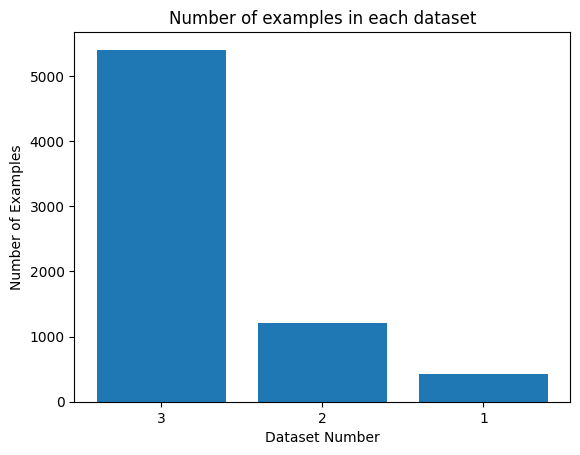

In [8]:
dataset_count = tile_metadata['dataset'].value_counts()

plt.bar(list(map(str, dataset_count.index)), dataset_count.values)

plt.xlabel('Dataset Number')
plt.ylabel('Number of Examples')
plt.title('Number of examples in each dataset')

plt.show()

In [9]:
print(f"Number of unlabbeled images: {dataset_count[dataset_count.index == 3].values[0]}, Number of annotated images: {np.sum(dataset_count[dataset_count.index != 3].values)}")

Number of unlabbeled images: 5400, Number of annotated images: 1633


## Understanding Source WSI

Whole Slide Images (WSIs), also known as virtual slides or digital slides, refer to high-resolution digital representations of entire histopathology glass slides. These slides are typically generated by scanning glass slides using specialized slide scanners.

We should expect 14 unique sources of WSIs where 5 have been used for annotations by either a expert or non expert which then get put into dataset 1 and 2 respectively, and the other 9 correspond to WSIs for dataset 3 which have no annotations. Although we should expect 14 we see that there is only thirteen. A keen eye would see that number 5 is missing. This is probably because the 5th WSI belongs to the first dataset and was removed from the dataset to be used as the test set.

In [10]:
print(f" There are {len(np.unique(tile_metadata.source_wsi))} unique source WSIs: {list(np.unique(tile_metadata.source_wsi))}")

 There are 13 unique source WSIs: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]


As we can see most of the Whole Slide Images (WSIs) contain 600 tiles

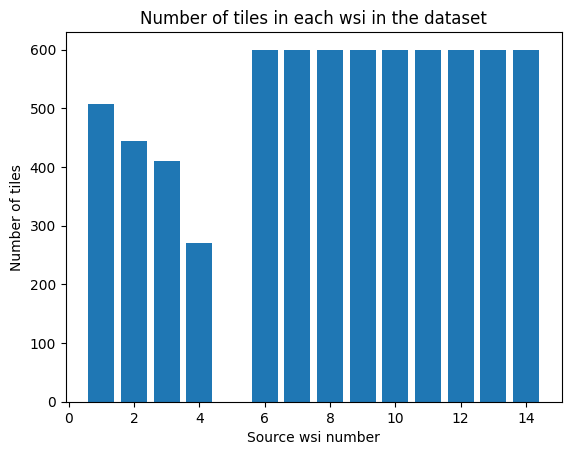

In [11]:
source_wsi_count = Counter(tile_metadata.source_wsi)

plt.bar(list(map(int, source_wsi_count.keys())), source_wsi_count.values())

plt.xlabel("Source wsi number")
plt.ylabel("Number of tiles")
plt.title("Number of tiles in each wsi in the dataset")

plt.show()

As we can see there are 9 WSIs used for dataset 3 and these are never used in dataset 1 and 2. We see dataset 2 has two unique WSIs 3 and 4 while WSIs 1 and 2 are split across dataset 1 and dataset 2. This means tiles from WSI 1 and 2 are annotated by experts or non experts, while tiles from WSIs 3 and 4 are labelled entierely by non experts and tiles from WSI 6, 7, 8, 9, 10, 11, 12, 13, 14 are not labelled at all

In [12]:
tile_metadata_ds = tile_metadata.groupby("dataset")

unique_wsi_3 = tile_metadata_ds.get_group(3).source_wsi.unique()
unique_wsi_2 = tile_metadata_ds.get_group(2).source_wsi.unique()
unique_wsi_1 = tile_metadata_ds.get_group(1).source_wsi.unique()

print(f"{len(unique_wsi_3)} WSIs in dataset_3 : {unique_wsi_3}, {len(unique_wsi_2)} WSIs in dataset_2 : {unique_wsi_2},{len(unique_wsi_1)} WSIs in dataset_1: {unique_wsi_1}")

9 WSIs in dataset_3 : [ 6  7  8  9 10 11 12 13 14], 4 WSIs in dataset_2 : [2 3 4 1],2 WSIs in dataset_1: [1 2]


## Understanding the Whole Slide Image metdata

In [13]:
wsi_metadata.head()

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


In [14]:
wsi_metadata.describe()

,source_wsi,age,height,weight,bmi
count,4.000000,4.000000,4.00000,4.000000,4.00000
mean,2.500000,60.000000,165.87500,89.775000,32.05000
std,1.290994,8.906926,6.68998,35.195679,9.91514
min,1.000000,53.000000,160.00000,59.000000,23.00000
25%,1.750000,55.250000,161.72500,69.500000,25.62500
50%,2.500000,57.000000,164.15000,80.250000,29.85000
75%,3.250000,61.750000,168.30000,100.525000,36.27500
max,4.000000,73.000000,175.20000,139.600000,45.50000


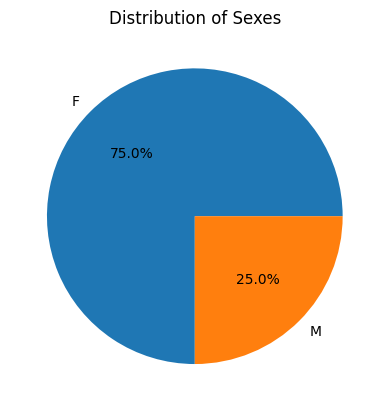

In [15]:
sex_counts = wsi_metadata.sex.value_counts()

plt.pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%')
plt.title("Distribution of Sexes")

plt.show()

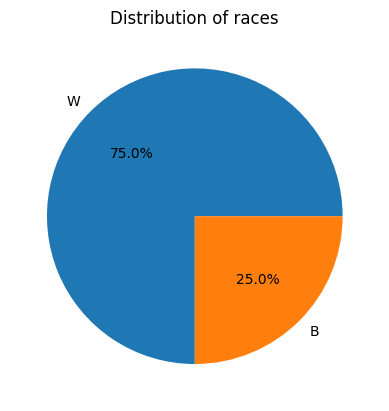

In [16]:
race_counts = wsi_metadata.race.value_counts()

plt.pie(race_counts.values, labels=race_counts.index, autopct='%1.1f%%')
plt.title("Distribution of races")

plt.show()

## Exploring Polygons.jsonl

In [17]:
polygons_df = pd.read_json(f"{BASE_DIR}polygons.jsonl", lines=True)
polygons_df.head()

,id,annotations
0,0006ff2aa7cd,"[{'type': 'glomerulus', 'coordinates': [[[167,..."
1,00168d1b7522,"[{'type': 'glomerulus', 'coordinates': [[[511,..."
2,0033bbc76b6b,"[{'type': 'blood_vessel', 'coordinates': [[[16..."
3,003504460b3a,"[{'type': 'blood_vessel', 'coordinates': [[[40..."
4,004daf1cbe75,"[{'type': 'blood_vessel', 'coordinates': [[[14..."


Each ID has only one set of annotations

In [18]:
polygons_df["id"].value_counts().unique() # each if only has one annotation

array([1], dtype=int64)

In [19]:
len(polygons_df) # this is the number of training examples

1633